# Prediciting Future Stock Price of Palantir Using LSTM Neural Network

In [42]:
import yfinance as yf

 Data Collection

In [43]:
# Download OHLCV Prive data for PLTR Stock for the past year with an interval of 1 day.
data = yf.download("PLTR", period="1y", interval="1d")
# View last 10 instances
print(data.tail(10))

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           PLTR       PLTR       PLTR       PLTR       PLTR
Date                                                             
2025-03-31  84.400002  84.650002  78.750000  80.000000  108092900
2025-04-01  84.680000  85.279999  81.820000  83.889999   78980700
2025-04-02  87.449997  88.404999  82.300003  82.400002   96563100
2025-04-03  83.599998  85.680000  81.010002  81.250000   93878200
2025-04-04  74.010002  80.980003  71.930000  80.070000  147323200
2025-04-07  77.839996  81.800003  66.120003  66.650002  169083700
2025-04-08  77.320000  86.113998  75.220001  83.290001  135345600
2025-04-09  92.010002  93.330002  77.269997  78.190002  187244300
2025-04-10  88.589996  90.779999  84.139999  88.400002  124448200
2025-04-11  88.550003  89.550003  85.470001  87.980003   94992700


Data Visualization

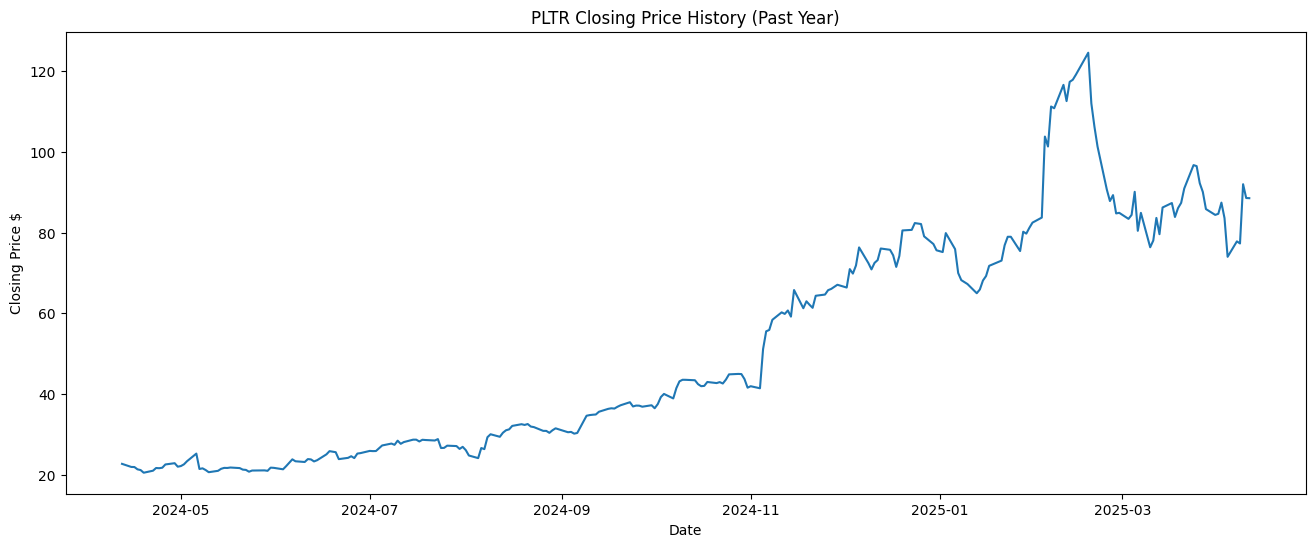

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the closing price of PLTR
plt.figure(figsize=(16,6))
plt.title("PLTR Closing Price History (Past Year)")
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.show()

Data Preprocessing

In [45]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Get only the 'Close' column
close = data[['Close']]

# Turn the pandas df to a numpy array
dataset = close.to_numpy()

# Normalize the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset)

# Split into training and testing sets
train_size = int(len(scaled_dataset) * 0.70)
train_data = scaled_dataset[:train_size]
test_data = scaled_dataset[train_size:]

def sequence(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0]) # 6o time steps
        y.append(data[i,0])               # the value right after

    return np.array(x), np.array(y)

x_train, y_train = sequence(train_data,60)
x_test, y_test = sequence(test_data,60)

# reshape to get 3D Inputs: (samples, time_steps, features)
# samples = number of sequences
# time steps = how many past values per sample
# features = 'Close'
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# N data points - sequence length = number of sequences
print(X_train.shape)
print(y_train.shape)


(115, 60, 1)
(115,)


Implementing the LSTM Network

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam 

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

In [47]:
# Create Tensors

X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(y_train).float()

# Creater Dataloader

dataset = TensorDataset(X_train_tensor, Y_train_tensor)
dataloader = DataLoader(dataset, shuffle=True)

class LSTM(nn.Module):
    
    def __init__(self, input_size = 1, hidden_size = 64, num_layers=2):
        
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # LSTM Layer connect to output layer
        self.fc = nn.Linear(hidden_size, 1)
        
    
    def forward(self, input):
        
        # input: (batch_size, seq_len, input_size)
        
        # intial hidden state (what the model rememebrs) and cell state (memeory across long sequences)
        h0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(input.device)
        
        # pass the input through the lstm layer
        # out = all hidden outputs for every time step 
        # _ = final hidden and cell states, not used here.
        # out: (batch_size, seq_len, hidden_size)
        out, _ = self.lstm(input, (h0,c0))
        
        
        # extracts last hidden state from the last time step and feeds it into the linear layer
        # ':' all batches. '-1' last time step. ':' all features in hidden state
        # shape = (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        
        return out

Train the Network

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM().to(device)

In [52]:

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

max_epochs = 1250
for epoch in range(max_epochs):
    model.train()
    
    # iterate through dataset in batches
    for X_batch, Y_batch in dataloader:
        
        # clear previous gradients
        optimizer.zero_grad()
        
        # forward pass
        output = model(X_batch)
        
        # compute loss 
        loss = loss_func(output.view(-1), Y_batch)
        
        # compute gradients (of loss with respect to weights), backpropagation
        loss.backward()
        
        # update parameters using computed gradients
        optimizer.step()
    
    print(f"Epoch: {epoch} , Loss: {loss.item()}")
        
    

Epoch: 0 , Loss: 1.0879252840823028e-06
Epoch: 1 , Loss: 0.0005227822111919522
Epoch: 2 , Loss: 6.806995770602953e-06
Epoch: 3 , Loss: 4.7140430979197845e-05
Epoch: 4 , Loss: 0.0004189791507087648
Epoch: 5 , Loss: 2.852239049389027e-05
Epoch: 6 , Loss: 9.023182201417512e-07
Epoch: 7 , Loss: 2.253262573503889e-05
Epoch: 8 , Loss: 0.0004955034237354994
Epoch: 9 , Loss: 0.00036181448376737535
Epoch: 10 , Loss: 0.00040729803731665015
Epoch: 11 , Loss: 0.00012907458585686982
Epoch: 12 , Loss: 1.1809571986987066e-07
Epoch: 13 , Loss: 0.00011500147229526192
Epoch: 14 , Loss: 0.0004492233565542847
Epoch: 15 , Loss: 0.00011591990187298506
Epoch: 16 , Loss: 0.0003650688740890473
Epoch: 17 , Loss: 0.00011105628800578415
Epoch: 18 , Loss: 0.00026719781453721225
Epoch: 19 , Loss: 4.1175673686666414e-05
Epoch: 20 , Loss: 0.0004142732941545546
Epoch: 21 , Loss: 7.80464761191979e-05
Epoch: 22 , Loss: 0.00017090793699026108
Epoch: 23 , Loss: 0.00030439774855040014
Epoch: 24 , Loss: 0.001226454274728894

Evaluate 

In [53]:
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

model.eval()

with torch.no_grad():
    prediction = model(X_test_tensor)
    predicted_price = prediction.detach().numpy()
    predicted = scaler.inverse_transform(predicted_price)

print(predicted)

[[79.30726 ]
 [78.9025  ]
 [78.34348 ]
 [77.85784 ]
 [78.33317 ]
 [78.67666 ]
 [78.37594 ]
 [77.97911 ]
 [78.44705 ]
 [78.86694 ]
 [78.63609 ]
 [77.69887 ]
 [78.106384]
 [79.59203 ]
 [78.80054 ]
 [78.81033 ]]
